### Record

This version is used for comparing the tradeoff

** Prepare two datasets for training and extracting sensitive attributes separately
1. Traning dataset: get dummy variables for gender
2. Sensitive attribute: gender is set to object

----
Process
1. Data preparation
   * \# of rows: 131097, # of clicks: 6091
   * choose gender as sensitive attribute 
   * \# of rows: 131097 -> 88652
 
2. Choose baseline model
    * logitsic regression predicting all the obs to 0
        * tpr and fpr are 0 when c changes from 0.01 to 10000
    * label predictions of cart changes as ccp_alpha changes
        * use default threshold
        * choose ccp_alpha in terms of tpr and fpr
3. Evaluate fairness in the baseline model using testing data
4. Incorparate fairness constraint
    * default
    * a list of difference_bound
    * a list of ratio_bound
5. Tradeoff 
    * percentage change of auc
    * percentage change of F1-score
    * percentage change of tpr and fpr
----

Question

1. What metrics to use for choosing hyperparameters in cart and random forest?
2.  Can we implement logistic regression in fairlearn?


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
# from sklearn.metrics import log_loss

In [2]:
com_ad = pd.read_csv('/Users/huizhihan/Desktop/imp_to_click_final.csv')
com_ad.drop(['Unnamed: 0'], axis=1, inplace=True)
# com_ad.info()
com_ad.head()

,Timestamp_impressions,Log Type,User-Agent_impressions,Region ID_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,20130606000104828,1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,216,219,1,336,280,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20130606000104915,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1...,333,334,2,250,250,2,0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,20130606000105049,1,Mozilla/5.0 (Linux; U; Android 4.1.1; zh-cn; M...,216,234,1,950,90,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20130606000105216,1,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2...,79,79,2,728,90,2,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20130606000105295,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.2...,80,86,1,300,250,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
com_ad['gender'] = com_ad['10110'] + com_ad['10111']

In [4]:
com_ad = com_ad[com_ad['gender']==1]
com_ad.shape

(88652, 65)

In [5]:
com_ad['10110'].isna().sum()

0

In [6]:
com_ad['10111'].isna().sum()

0

In [7]:
com_ad = com_ad.drop(['gender','10111'],axis=1)
com_ad = com_ad.rename(columns={'10110':'is_male'})

In [8]:
# fillna with 0 to indicate if a specific user profile exists
com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']] = com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']].fillna(0)

com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']]

,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131092,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131093,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131094,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131095,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
ad_imp = com_ad[['Timestamp_impressions', 'Log Type', 
       'Region ID_impressions', 'City ID', 'Ad Exchange', 'Ad Slot Width',
       'Ad Slot Height', 'Ad Slot Visibility', 'Ad Slot Format',
       'Ad Slot Floor Price', 'Bidding Price', 'Paying Price', 'Advertiser ID',
       'has click',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063',
       '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093',
       '10102', 'is_male', '10684', '11092', '11278', '11379', '11423',
       '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403',
       '13496', '13678', '13776', '13800', '13866', '13874', '14273', '16593',
       '16617', '16661', '16706']]

ad_imp.shape

(88652, 56)

In [10]:
ad_imp = ad_imp.drop(['City ID'], axis=1)
ad_imp.shape

(88652, 55)

In [11]:
ad_imp_summary = ad_imp.describe()
ad_imp_summary

,Timestamp_impressions,Log Type,Region ID_impressions,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
count,8.865200e+04,88652.0,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,...,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000
mean,2.013061e+16,1.0,143.652033,2.074753,596.181812,192.394193,3.098091,0.364391,27.381920,268.064680,...,0.022932,0.061014,0.123663,0.236836,0.001072,0.129642,0.001286,0.001974,0.003305,0.002008
std,1.984319e+09,0.0,102.245699,0.839593,328.123548,132.482990,23.979628,0.681330,34.636356,30.345306,...,0.149689,0.239357,0.329199,0.425143,0.032718,0.335911,0.035837,0.044386,0.057395,0.044764
min,2.013061e+16,1.0,0.000000,1.000000,120.000000,60.000000,0.000000,0.000000,0.000000,227.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.013061e+16,1.0,65.000000,1.000000,300.000000,90.000000,0.000000,0.000000,0.000000,238.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.013061e+16,1.0,134.000000,2.000000,468.000000,90.000000,0.000000,0.000000,5.000000,254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.013061e+16,1.0,216.000000,3.000000,1000.000000,250.000000,2.000000,1.000000,50.000000,300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.013061e+16,1.0,395.000000,3.000000,1000.000000,600.000000,255.000000,5.000000,295.000000,300.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# filter constant feature [std = 0]
ad_imp_summary.loc['std'][ad_imp_summary.loc['std'] == 0]

Log Type    0.0
Name: std, dtype: float64

In [13]:
# drop feature Log Type because it's a constant
ad_imp.drop(['Log Type'], axis=1, inplace=True)
ad_imp.shape

(88652, 54)

In [14]:
# filter has impression == 1 to get the suitable dataset
ad_imp2clk = ad_imp.copy()

In [15]:
# set ad exchange as object to get dummy variables
ad_imp2clk['Ad Exchange'] = ad_imp2clk['Ad Exchange'].astype('object')
# set ad slot visibility as object to get dummy variables
ad_imp2clk['Ad Slot Visibility'] = ad_imp2clk['Ad Slot Visibility'].astype('object')
# set ad slot format as object to get dummy variables
ad_imp2clk['Ad Slot Format'] = ad_imp2clk['Ad Slot Format'].astype('object')
# set advertiser id as object to get dummy variables
ad_imp2clk['Advertiser ID'] = ad_imp2clk['Advertiser ID'].astype('object')
# set region id as object to get dummy variables
ad_imp2clk['Region ID_impressions'] = ad_imp2clk['Region ID_impressions'].astype('object')
# set is_male as object to get dummy variables
ad_imp2clk['is_male'] = ad_imp2clk['is_male'].astype('object')

In [16]:
# use earlier five days as training data
imp2clk_train = ad_imp2clk[ad_imp2clk['Timestamp_impressions']<20130611000000000]
print(imp2clk_train.shape)
# use the following two days as testing data
imp2clk_test = ad_imp2clk[ad_imp2clk['Timestamp_impressions']>=20130611000000000]
print(imp2clk_test.shape)

(64798, 54)
(23854, 54)


In [18]:
imp2clk_train[imp2clk_train['has click']==0].shape

(60665, 54)

In [19]:
# training set without dummy variables
X1_train = imp2clk_train.drop('has click',axis=1)
y1_train = imp2clk_train['has click']

In [20]:
# testing set without dummy variables
X1_test = imp2clk_test.drop('has click',axis=1)
y1_test = imp2clk_test['has click']

In [21]:
X1_train.columns

Index(['Timestamp_impressions', 'Region ID_impressions', 'Ad Exchange',
       'Ad Slot Width', 'Ad Slot Height', 'Ad Slot Visibility',
       'Ad Slot Format', 'Ad Slot Floor Price', 'Bidding Price',
       'Paying Price', 'Advertiser ID', '10006', '10024', '10031', '10048',
       '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076',
       '10077', '10079', '10083', '10093', '10102', 'is_male', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680',
       '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800',
       '13866', '13874', '14273', '16593', '16617', '16661', '16706'],
      dtype='object')

In [22]:
# convert region id into dummy variables
ad_imp2clk_enc = pd.get_dummies(ad_imp2clk, columns = ['Ad Exchange', 'Ad Slot Visibility','Ad Slot Format','Region ID_impressions','Advertiser ID','is_male'])
ad_imp2clk_enc.head()

,Timestamp_impressions,Ad Slot Width,Ad Slot Height,Ad Slot Floor Price,Bidding Price,Paying Price,has click,10006,10024,10031,...,Region ID_impressions_393,Region ID_impressions_394,Region ID_impressions_395,Advertiser ID_1458,Advertiser ID_3358,Advertiser ID_3386,Advertiser ID_3427,Advertiser ID_3476,is_male_0.0,is_male_1.0
0,20130606000104828,336,280,0,300,51,0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,20130606000104915,250,250,23,249,68,0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,1
3,20130606000105216,728,90,5,238,45,0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,1
9,20130606000105938,728,90,5,249,45,0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,1
12,20130606000106153,950,90,0,227,109,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [23]:
# use earlier five days as training data 
imp2clk_train_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions']<20130611000000000]
# use the following two days as testing data
imp2clk_test_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions'] >= 20130611000000000]

In [24]:
# baseline model
train_clk = np.sum(imp2clk_train_enc['has click']==1)
train_not_clk = np.sum(imp2clk_train_enc['has click']==0)

print(pd.Series({'0': train_not_clk, '1': train_clk}))

# baseline model should predict not click for all observations in the test set

0    60665
1     4133
dtype: int64


In [25]:
# baseline model prediction probability
baseline_clk_prob = train_clk / (train_clk + train_not_clk)
baseline_clk_prob

0.06378283280348158

In [26]:
# filter all constant features in the impression training set
imp2clk_train_enc_summary = imp2clk_train_enc.describe()
imp2clk_train_enc_summary.loc['std'][imp2clk_train_enc_summary.loc['std'] == 0]

Series([], Name: std, dtype: float64)

In [27]:
# encoded training set
X1_train_enc = imp2clk_train_enc.drop('has click', axis=1)
y1_train_enc = imp2clk_train_enc['has click']

In [28]:
# encoded testing set
X1_test_enc = imp2clk_test_enc.drop('has click', axis=1)
y1_test_enc = imp2clk_test_enc['has click']

In [29]:
y1_test_enc.sum()

1958

In [30]:
y1_train_enc.sum()

4133

### Evaluating fairness

In [34]:
# Sensitive attribute 10110 used for training
gender_train = X1_train['is_male']

In [35]:
# sensitive attribute used for testing
gender_test = X1_test['is_male']

In [36]:
gender_test

94335     0.0
94337     0.0
94341     1.0
94346     1.0
94347     1.0
         ... 
131092    1.0
131093    1.0
131094    1.0
131095    1.0
131096    0.0
Name: is_male, Length: 23854, dtype: object

## Metigating disparity 

#### CART

In [37]:
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)

In [38]:
X1_train_enc.shape

(64798, 99)

In [39]:
y1_train_enc.shape

(64798,)

In [40]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import time 

tic = time.time()
np.random.seed(0)
constraint = DemographicParity()
mitigator_dtc = ExponentiatedGradient(classifier_dtc, constraint)
mitigator_dtc.fit(X1_train_enc, y1_train_enc, sensitive_features=gender_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 86.73 s


In [41]:
y1_pred_dtc_mitigated = mitigator_dtc.predict(X1_train_enc)

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

In [43]:
classifier_dtc_base = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)
classifier_dtc_base.fit(X1_train_enc, y1_train_enc)
y1_pred_dtc = classifier_dtc_base.predict(X1_train_enc)

#### TPR

In [49]:
tpr_dtc_mitigated = MetricFrame(tpr, y1_train_enc, y1_pred_dtc_mitigated, sensitive_features=gender_train)

In [50]:
print(tpr_dtc_mitigated.overall)

0.5981127510283087


In [51]:
print(tpr_dtc_mitigated.by_group)

is_male
0.0    0.628995
1.0    0.575388
Name: tpr, dtype: object


In [52]:
tpr_dtc = tpr(y1_train_enc, y1_pred_dtc)
tpr_dtc

0.567384466489233

#### FPR

In [53]:
fpr_dtc_mitigated = MetricFrame(fpr, y1_train_enc, y1_pred_dtc_mitigated, sensitive_features=gender_train)
print('Mitigated fpr of CART is: ', fpr_dtc_mitigated.overall)
print('Mitigated fpr of CART by group is:\n', fpr_dtc_mitigated.by_group)

Mitigated fpr of CART is:  0.006478199950548092
Mitigated fpr of CART by group is:
 is_male
0.0    0.001925
1.0    0.008591
Name: fpr, dtype: object


In [54]:
fpr_dtc = fpr(y1_train_enc, y1_pred_dtc)
fpr_dtc

0.0027857908184290778

#### F1-score

In [55]:
from sklearn.metrics import f1_score
f1_dtc_mitigated = MetricFrame(f1_score, y1_train_enc, y1_pred_dtc_mitigated, sensitive_features=gender_train)
f1_dtc_mitigated.overall

0.7064875678765361

In [56]:
f1_dtc_mitigated.by_group

is_male
0.0    0.762366
1.0    0.667154
Name: f1_score, dtype: object

In [57]:
f1_dtc = f1_score(y1_train_enc, y1_pred_dtc)
f1_dtc

0.7055814653227019

#### Comparison with baseline

In [58]:
# percentage decrease of TPR
(tpr_dtc - tpr_dtc_mitigated.overall)/tpr_dtc

-0.05415778251599145

In [59]:
# percentage decrease of FPR
(fpr_dtc - fpr_dtc_mitigated.overall) / fpr_dtc

-1.3254437869822484

#### Tradeoff

In [60]:
# a list of difference_bound
bound_list = list(np.linspace(0, 0.05, 50))
# relative change of tpr
tpr_dtc_list = [np.nan]*len(bound_list)
# relative change of fpr
fpr_dtc_list = [np.nan]*len(bound_list)
# relative change of F1-score
f1_dtc_list = [np.nan]*len(bound_list)

In [61]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import time


# baseline
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, 
                                            min_samples_split=20, max_depth=30, random_state=88)

tic = time.time()

for i in range(len(bound_list)):
    sample_i = bound_list[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_dtc = ExponentiatedGradient(classifier_dtc, constraint)
    mitigator_dtc.fit(X1_train_enc, y1_train_enc, sensitive_features=gender_train)
    y1_pred_dtc = mitigator_dtc.predict(X1_test_enc)
   
    
    # evaluating fairness in terms of f1-score
    f1_mitigated_i = MetricFrame(f1_score, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    relative_decrease_f1_i = (f1_dtc - f1_mitigated_i.overall) / f1_dtc
    f1_dtc_list[i] = relative_decrease_f1_i
    
    # evaluating fairness in terms of tpr
    tpr_dtc_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    relative_decrease_tpr_i = (tpr_dtc - tpr_dtc_mitigated_i.overall) / tpr_dtc
    tpr_dtc_list[i] = relative_decrease_tpr_i
    
    # evaluating fairness in terms of fpr
    fpr_dtc_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    relative_decrease_fpr_i = (fpr_dtc - fpr_dtc_mitigated_i.overall) / fpr_dtc
    fpr_dtc_list[i] = relative_decrease_fpr_i
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

time: 1931.94 s


In [62]:
bound_list

[0.0,
 0.0010526315789473684,
 0.002105263157894737,
 0.003157894736842105,
 0.004210526315789474,
 0.005263157894736842,
 0.00631578947368421,
 0.007368421052631579,
 0.008421052631578947,
 0.009473684210526315,
 0.010526315789473684,
 0.011578947368421053,
 0.01263157894736842,
 0.013684210526315788,
 0.014736842105263158,
 0.015789473684210527,
 0.016842105263157894,
 0.017894736842105262,
 0.01894736842105263,
 0.02]

In [63]:
tpr_dtc_list
# tpr_dtc_list_r = list(reversed(tpr_dtc_list))

[-0.09936034115138587,
 -0.1019189765458422,
 -0.09978678038379529,
 -0.09978678038379529,
 -0.09680170575692955,
 -0.09552238805970148,
 -0.09040511727078883,
 -0.06908315565031979,
 -0.060554371002132165,
 -0.05586353944562894,
 -0.053304904051172615,
 -0.049893390191897646,
 -0.043496801705756934,
 -0.034541577825159896,
 -0.026439232409381695,
 -0.021748400852878467,
 -0.015778251599147173,
 -0.017910447761194076,
 -0.016631130063965816,
 -0.016631130063965816]

In [64]:
fpr_dtc_list
# fpr_dtc_list_r = list(reversed(fpr_dtc_list))

[-2.840236686390533,
 -2.7633136094674553,
 -2.6272189349112427,
 -2.5266272189349115,
 -2.337278106508876,
 -2.106508875739645,
 -2.0118343195266273,
 -1.668639053254438,
 -1.4378698224852071,
 -1.378698224852071,
 -1.21301775147929,
 -1.0710059171597635,
 -1.0059171597633136,
 -0.8816568047337277,
 -0.7337278106508877,
 -0.5502958579881656,
 -0.4319526627218936,
 -0.30769230769230765,
 -0.21893491124260359,
 -0.21893491124260359]

In [65]:
comparison_dtc = pd.DataFrame({'difference_bound':bound_list, 
                               'decrease%_f1': f1_dtc_list,
                               'decrease%_tpr': tpr_dtc_list,
                               'decrease%_fpr': fpr_dtc_list})

In [66]:
comparison_dtc.head(10)

,difference_bound,decrease%_f1,decrease%_tpr,decrease%_fpr
0,0.000000,0.007140,-0.099360,-2.840237
1,0.001053,0.003882,-0.101919,-2.763314
2,0.002105,0.002009,-0.099787,-2.627219
3,0.003158,-0.000312,-0.099787,-2.526627
4,0.004211,-0.002950,-0.096802,-2.337278
5,0.005263,-0.007602,-0.095522,-2.106509
6,0.006316,-0.006796,-0.090405,-2.011834
7,0.007368,-0.002143,-0.069083,-1.668639
8,0.008421,-0.002489,-0.060554,-1.437870
9,0.009474,-0.001045,-0.055864,-1.378698


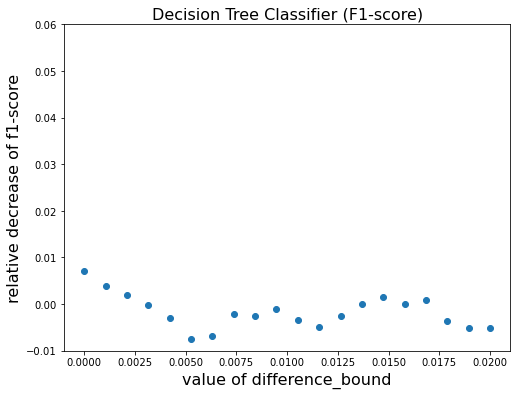

In [67]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (F1-score)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of f1-score', fontsize=16)
plt.ylim([-0.01, 0.06])
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['decrease%_f1'])

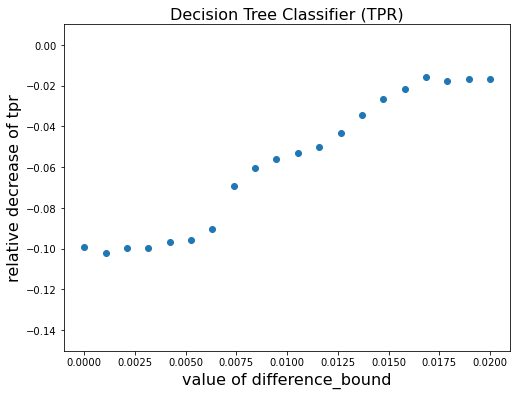

In [74]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (TPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of tpr', fontsize=16)
plt.ylim([-0.15, 0.01])
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['decrease%_tpr'])

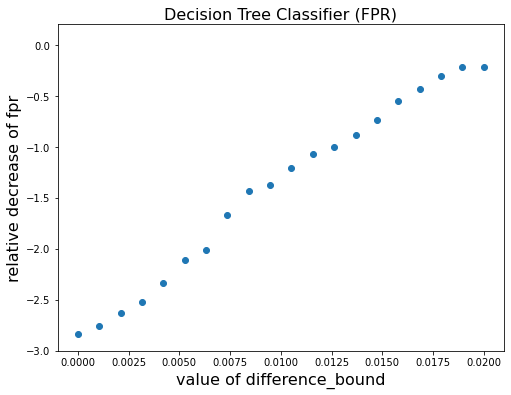

In [77]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (FPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of fpr', fontsize=16)
plt.ylim([-3,0.2])
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['decrease%_fpr'])

In [70]:
comparison_dtc.head(10)

,difference_bound,decrease%_f1,decrease%_tpr,decrease%_fpr
0,0.000000,0.007140,-0.099360,-2.840237
1,0.001053,0.003882,-0.101919,-2.763314
2,0.002105,0.002009,-0.099787,-2.627219
3,0.003158,-0.000312,-0.099787,-2.526627
4,0.004211,-0.002950,-0.096802,-2.337278
5,0.005263,-0.007602,-0.095522,-2.106509
6,0.006316,-0.006796,-0.090405,-2.011834
7,0.007368,-0.002143,-0.069083,-1.668639
8,0.008421,-0.002489,-0.060554,-1.437870
9,0.009474,-0.001045,-0.055864,-1.378698


#### Random forest

In [83]:
classifier_rf = RandomForestClassifier(max_features=9, min_samples_leaf=5, max_depth=30, n_estimators=500, random_state=88)

In [84]:
classifier_rf.fit(X1_train_enc, y1_train_enc)
y1_pred_rf = classifier_rf.predict(X1_train_enc)

In [85]:
tpr_rf = tpr(y1_train_enc, y1_pred_rf)
fpr_rf = fpr(y1_train_enc, y1_pred_rf)

In [86]:
f1_rf=f1_score(y1_train_enc, y1_pred_rf)

#### difference_bound

In [87]:
# # a list of difference_bound

bound_list = list(np.linspace(0, 0.05, 50))
# relative change of tpr
tpr_rf_list = [np.nan]*len(bound_list)
# relative change of fpr
fpr_rf_list = [np.nan]*len(bound_list)
# relative change of F1-score
f1_rf_list = [np.nan]*len(bound_list)


In [88]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
import time


# baseline
classifier_rf = RandomForestClassifier(max_features=9, min_samples_leaf=5, 
                                       max_depth=30, n_estimators=500, random_state=88)

tic = time.time()

for i in range(len(bound_list)):
    sample_i = bound_list[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_rf = ExponentiatedGradient(classifier_rf, constraint)
    mitigator_rf.fit(X1_train_enc, y1_train_enc, sensitive_features=gender_train)
    y1_pred_rf = mitigator_rf.predict(X1_test_enc)
    
    
    # evaluating fairness in terms of f1-score
    f1_rf_mitigated_i = MetricFrame(f1_score, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
    relative_change_f1_i = (f1_rf - f1_rf_mitigated_i.overall) / f1_rf
    f1_rf_list[i] = relative_change_f1_i
    
    
    # evaluating fairness in terms of tpr
    tpr_rf_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
    relative_change_tpr_i = (tpr_rf - tpr_rf_mitigated_i.overall) / tpr_rf
    tpr_rf_list[i] = relative_change_tpr_i
    
    #evaluating fairness in terms of fpr
    fpr_rf_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
    relative_change_fpr_i = (fpr_rf - fpr_rf_mitigated_i.overall) / fpr_rf
    fpr_rf_list[i] = relative_change_fpr_i
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

time: 30063.36 s


In [89]:
bound_list

[0.0,
 0.0010526315789473684,
 0.002105263157894737,
 0.003157894736842105,
 0.004210526315789474,
 0.005263157894736842,
 0.00631578947368421,
 0.007368421052631579,
 0.008421052631578947,
 0.009473684210526315,
 0.010526315789473684,
 0.011578947368421053,
 0.01263157894736842,
 0.013684210526315788,
 0.014736842105263158,
 0.015789473684210527,
 0.016842105263157894,
 0.017894736842105262,
 0.01894736842105263,
 0.02]

In [90]:
tpr_rf_list

[-0.006711409395973166,
 -0.033040784718637084,
 -0.006195147134744416,
 -0.03871966959215275,
 -0.0020650490449147657,
 -0.03458957150232322,
 0.0015487867836861335,
 -0.041300980898296265,
 -0.04078471863706763,
 -0.04336602994321115,
 0.013422818791946333,
 -0.03510583376355185,
 -0.029426948890036064,
 0.010325245224574066,
 0.004646360351058401,
 -0.022199277232834266,
 0.0025813113061435165,
 -0.01652039235931848,
 -0.017036654620547233,
 -0.018069179143004616]

In [91]:
fpr_rf_list

[-10.666666666666666,
 -11.925925925925926,
 -8.444444444444445,
 -11.037037037037036,
 -6.518518518518519,
 -9.629629629629632,
 -5.0,
 -7.703703703703703,
 -7.148148148148148,
 -6.444444444444445,
 -2.2222222222222223,
 -4.7407407407407405,
 -3.3703703703703702,
 -0.29629629629629634,
 0.03703703703703707,
 -2.1851851851851856,
 -0.03703703703703707,
 -0.03703703703703707,
 -0.03703703703703707,
 -0.07407407407407414]

In [92]:
comparison_rf = pd.DataFrame({'difference_bound':bound_list, 
                               'decrease%_f1': f1_rf_list,
                               'decrease%_tpr': tpr_rf_list,
                               'decrease%_fpr': fpr_rf_list})

In [93]:
comparison_rf.head(10)

,difference_bound,decrease%_f1,decrease%_tpr,decrease%_fpr
0,0.000000,-0.116168,-0.006711,-10.666667
1,0.001053,-0.116168,-0.033041,-11.925926
2,0.002105,-0.116168,-0.006195,-8.444444
3,0.003158,-0.116168,-0.038720,-11.037037
4,0.004211,-0.116168,-0.002065,-6.518519
5,0.005263,-0.116168,-0.034590,-9.629630
6,0.006316,-0.116168,0.001549,-5.000000
7,0.007368,-0.116168,-0.041301,-7.703704
8,0.008421,-0.116168,-0.040785,-7.148148
9,0.009474,-0.116168,-0.043366,-6.444444


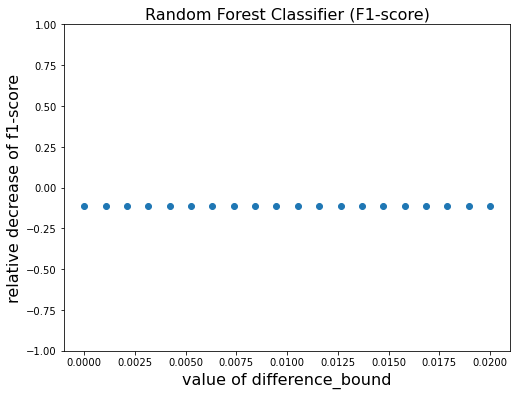

In [104]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (F1-score)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of f1-score', fontsize=16)
plt.ylim([-1, 1])
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['decrease%_f1'])

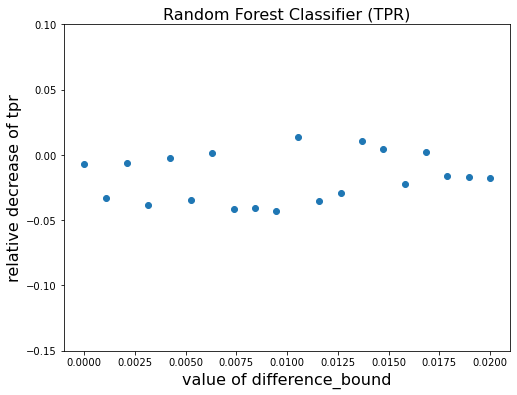

In [98]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (TPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of tpr', fontsize=16)
plt.ylim([-0.15, 0.1])
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['decrease%_tpr'])

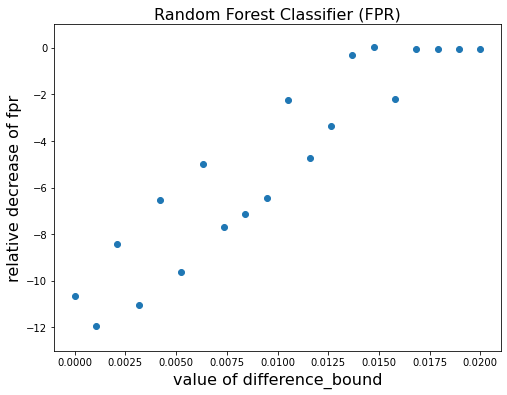

In [103]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (FPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('relative decrease of fpr', fontsize=16)
plt.ylim([-13,1])
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['decrease%_fpr'])